In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from kcorrect.kcorrect import Kcorrect
from lf_utils import *
from lf_ev import *


import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
df = pd.read_parquet(r"E:\PhD\Jon\SHARK\waves_deep_gals.parquet")
df=df[(df['total_ap_dust_Z_VISTA']>-999.0) & (df['zobs']<=1)]
df['SC'] = 7
df['NQ'] = 3

In [3]:
df

,id_galaxy_sky,ra,dec,zobs,zcos,inclination,pa,mstars_disk,mstars_bulge,mvir_hosthalo,...,total_ab_dust_Band3_ALMA,total_ab_dust_BandX_VLA,total_ab_dust_BandC_VLA,total_ab_dust_BandS_VLA,total_ab_dust_BandL_VLA,total_ab_dust_Band_610MHz,total_ab_dust_Band_325MHz,total_ab_dust_Band_150MHz,SC,NQ
0,3265,350.756989,-33.923721,0.588395,0.585817,68.890175,131.778320,8.345707e+09,2.120054e+10,3.476077e+12,...,-19.112677,-19.950594,-20.326777,-20.828455,-21.363056,-22.031427,-22.569828,-23.272591,7,3
1,3270,350.755951,-33.922852,0.587875,0.585816,62.644188,141.846848,4.605616e+07,1.588754e+10,3.476077e+12,...,-12.224907,-13.216760,-13.592941,-14.094620,-14.629221,-15.297593,-15.835993,-16.538755,7,3
2,3272,348.082520,-34.985603,0.580570,0.578419,53.682911,44.502815,1.128947e+07,8.872880e+09,4.115418e+11,...,-18.515173,-19.445467,-19.821650,-20.323328,-20.857929,-21.526300,-22.064701,-22.767464,7,3
3,3275,350.980164,-33.894814,0.587297,0.585086,59.386322,26.838942,2.406996e+08,3.698360e+10,1.077890e+12,...,-20.027172,-20.834003,-21.210184,-21.711863,-22.246464,-22.914835,-23.453236,-24.155998,7,3
4,3278,348.977997,-34.310123,0.587991,0.586444,15.724483,189.237732,4.484061e+06,1.050976e+10,6.535080e+11,...,-19.710293,-20.582624,-20.958805,-21.460484,-21.995085,-22.663458,-23.201857,-23.904619,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375989,35843129,345.938141,-30.317612,0.833578,0.834314,61.004955,86.400681,0.000000e+00,3.344424e+10,2.912006e+12,...,-19.368702,-20.219265,-20.595448,-21.097126,-21.631727,-22.300098,-22.838499,-23.541262,7,3
375990,35843175,343.201233,-32.280529,0.840579,0.838226,81.507042,103.734207,1.338794e+09,2.274401e+10,2.406822e+12,...,-17.926683,-18.900578,-19.276758,-19.778439,-20.313038,-20.981411,-21.519810,-22.222572,7,3
375991,35843202,343.866730,-30.794127,0.836563,0.833475,34.940994,255.186386,2.812586e+06,1.261372e+10,6.205226e+11,...,-19.363466,-20.266329,-20.642509,-21.144188,-21.678789,-22.347162,-22.885561,-23.588324,7,3
375992,35843476,347.121613,-31.806978,0.835292,0.833175,83.777840,89.561821,5.599804e+09,2.110444e+10,1.651923e+12,...,-20.540680,-21.415684,-21.791864,-22.293543,-22.828144,-23.496515,-24.034916,-24.737679,7,3


In [4]:
mag_cols = {'u_VST': 'total_ap_dust_u_VST', 
            'g_VST': 'total_ap_dust_g_VST', 
            'r_VST': 'total_ap_dust_r_VST', 
            'i_VST': 'total_ap_dust_i_VST', 
            'Z_VISTA': 'total_ap_dust_Z_VISTA', 
            'Y_VISTA': 'total_ap_dust_Y_VISTA', 
            'J_VISTA': 'total_ap_dust_J_VISTA', 
            'H_VISTA': 'total_ap_dust_H_VISTA', 
            'K_VISTA': 'total_ap_dust_K_VISTA'}
Mag_cols = {'u_VST': 'total_ab_dust_u_VST', 
            'g_VST': 'total_ab_dust_g_VST', 
            'r_VST': 'total_ab_dust_r_VST', 
            'i_VST': 'total_ab_dust_i_VST', 
            'Z_VISTA': 'total_ab_dust_Z_VISTA', 
            'Y_VISTA': 'total_ab_dust_Y_VISTA', 
            'J_VISTA': 'total_ab_dust_J_VISTA', 
            'H_VISTA': 'total_ab_dust_H_VISTA', 
            'K_VISTA': 'total_ab_dust_K_VISTA'}

cosmo = LambdaCDM(H0=67.51, Om0=0.3, Ode0=0.7)
dist_mod = 5 * np.log10(cosmo.luminosity_distance(df['zcos']).to(u.parsec).value)

fnames=[]
kcorr = []
for band in mag_cols:
    m = df[mag_cols[band]].values
    M = df[Mag_cols[band]].values
    k = m - dist_mod + 5 - M
    df[f'kcorr_{band}'] = k
    df[f'flux_{band}'] = 10**((8.9-m)/2.5)
    fnames.append(f'flux_{band}')

In [5]:
kc = Kcorrect(responses = ['vst_u', 'vst_g', 'vst_r', 'vst_i', 'vista_z', 'vista_y', 'vista_j', 'vista_h', 'vista_k'])
redshift = df['zobs'].values
flux = df[fnames].values
flux_err = flux * 0.01
ivar = np.minimum(flux_err**-2, 1e30)
fix = (flux > 1e10) + (flux < -900) + (flux_err <= 0)
flux[fix] = 0
ivar[fix] = 0
coeffs = kc.fit_coeffs(redshift, flux, ivar)

ztol = 0.1
rz = df[fnames[4]]/df[fnames[4]]
bad = np.nonzero(coeffs.sum(axis=-1) == 0)[0]
good = (coeffs.sum(axis=-1) > 0)
nbad = len(bad)
if nbad > 0:
    for ibad in bad:
        print('Replacing', nbad, 'bad fits with mean')
        close = np.nonzero((abs(redshift - redshift[ibad]) < ztol) *
                            (0.9 < rz[ibad]/rz[good]) * (rz[ibad]/rz[good] < 1.1))[0]
        if len(close) > 0:
            coeffs[ibad, :] = np.mean(coeffs[close, :], axis=0)
        else:
            coeffs[ibad, :] = np.mean(coeffs[good, :], axis=0)
df['kcoeffs'] = coeffs.tolist()
df['pcoeffs_vista_z'] = [[0, 0, 0, 0, 0]] * len(df)

c:\Users\adrie\AppData\Local\Programs\Python\Python313\Lib\site-packages\kcorrect\template.py:226: RuntimeWarning: underflow encountered in divide
  self.flux = self.restframe_flux / (1. + redshift)


In [6]:
df = luminosity_distance(df, redshift='zobs', H0=67.51, Om0=0.3, Ode0=0.7)

In [7]:
df

,id_galaxy_sky,ra,dec,zobs,zcos,inclination,pa,mstars_disk,mstars_bulge,mvir_hosthalo,...,flux_Y_VISTA,kcorr_J_VISTA,flux_J_VISTA,kcorr_H_VISTA,flux_H_VISTA,kcorr_K_VISTA,flux_K_VISTA,kcoeffs,pcoeffs_vista_z,Lum_Distance
0,3265,350.756989,-33.923721,0.588395,0.585817,68.890175,131.778320,8.345707e+09,2.120054e+10,3.476077e+12,...,0.000029,-0.082842,0.000039,-0.208240,0.000053,-0.557461,0.000060,"[0.00011042267578886822, 1.509678071442977e-07...","[0, 0, 0, 0, 0]",3.574702e+09
1,3270,350.755951,-33.922852,0.587875,0.585816,62.644188,141.846848,4.605616e+07,1.588754e+10,3.476077e+12,...,0.000022,-0.196542,0.000029,-0.278684,0.000036,-0.610448,0.000039,"[0.0, 0.0, 0.00025813031243160367, 0.001877067...","[0, 0, 0, 0, 0]",3.570874e+09
2,3272,348.082520,-34.985603,0.580570,0.578419,53.682911,44.502815,1.128947e+07,8.872880e+09,4.115418e+11,...,0.000018,-0.278914,0.000022,-0.334465,0.000026,-0.642241,0.000028,"[0.0, 3.66290549891346e-07, 0.0001351623504888...","[0, 0, 0, 0, 0]",3.517177e+09
3,3275,350.980164,-33.894814,0.587297,0.585086,59.386322,26.838942,2.406996e+08,3.698360e+10,1.077890e+12,...,0.000020,-0.051435,0.000027,-0.161042,0.000037,-0.472413,0.000043,"[0.00027328013675287366, 2.88773037482315e-07,...","[0, 0, 0, 0, 0]",3.566620e+09
4,3278,348.977997,-34.310123,0.587991,0.586444,15.724483,189.237732,4.484061e+06,1.050976e+10,6.535080e+11,...,0.000026,-0.261957,0.000031,-0.322296,0.000038,-0.622865,0.000041,"[0.00011932139750570059, 3.656607532320777e-07...","[0, 0, 0, 0, 0]",3.571729e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375989,35843129,345.938141,-30.317612,0.833578,0.834314,61.004955,86.400681,0.000000e+00,3.344424e+10,2.912006e+12,...,0.000019,-0.065725,0.000024,-0.227407,0.000034,-0.623386,0.000041,"[6.401169230230153e-05, 9.454197424929589e-08,...","[0, 0, 0, 0, 0]",5.472887e+09
375990,35843175,343.201233,-32.280529,0.840579,0.838226,81.507042,103.734207,1.338794e+09,2.274401e+10,2.406822e+12,...,0.000016,-0.132669,0.000020,-0.303733,0.000028,-0.709388,0.000032,"[0.0, 1.2855645081799594e-07, 0.00013791951641...","[0, 0, 0, 0, 0]",5.529549e+09
375991,35843202,343.866730,-30.794127,0.836563,0.833475,34.940994,255.186386,2.812586e+06,1.261372e+10,6.205226e+11,...,0.000014,-0.357094,0.000016,-0.440327,0.000019,-0.751793,0.000021,"[5.8369867474539205e-05, 4.5914916313449794e-0...","[0, 0, 0, 0, 0]",5.497035e+09
375992,35843476,347.121613,-31.806978,0.835292,0.833175,83.777840,89.561821,5.599804e+09,2.110444e+10,1.651923e+12,...,0.000026,-0.278280,0.000030,-0.378717,0.000037,-0.713068,0.000042,"[0.00020744538051076233, 6.877896225887525e-07...","[0, 0, 0, 0, 0]",5.486752e+09


In [8]:
df.to_pickle(r"E:\PhD\Jon\pickle datafiles\SHARK_deep_dataframe.pkl")

In [9]:
# import pandas as pd
# df = pd.read_pickle(r"E:\PhD\Jon\pickle datafiles\SHARK_deep_dataframe.pkl")
# from lf_ev import *

c:\Users\adrie\AppData\Local\Programs\Python\Python313\Lib\site-packages\kcorrect\template.py:226: RuntimeWarning: underflow encountered in divide
  self.flux = self.restframe_flux / (1. + redshift)



************************
jswml.py version  2.0
Using Blanton kcorrections
survey :  GAMAIII
ref_mlims :  (0, 21.25)
band_mlims :  (0, 21.25)
redshift range : [ 0.002 ;  0.65 ]
area : 50.59
method :  post
Kcorrect responses :  ['vst_u', 'vst_g', 'vst_r', 'vst_i', 'vista_z', 'vista_y', 'vista_j', 'vista_h', 'vista_k']
Error type :  jackknife
Jackknife regions :  (339, 343, 347)
{}
H0, omega_l, z0, area/Sr =  67.51 0.7 0.1 0.015409813039937317
319018 galaxies selected
No column r_sb; ignoring SB completeness
No column fibermag_r; ignoring redshift completeness
Setting LF bin limits Qmin, Qmax =  -2.0 2.0
LF bins with more than 10 gals :  [   16    23    34    83   151   253   467  1062  2381  5633 11811 20746
 29204 35075 37776 39064 35563 27655 19366 13358  9447  7024  5160  4081
  3035  2338  1877  1459   998   761   776   596   406   330   259   187
   167    88    76    49    37    27    32]
Q, P chi^2 grid using post
P [-1.25 -0.75 -0.25  0.25  0.75  1.25  1.75]
Q [-1.75 -1.25 -0.75

  0%|          | 0/8 [00:00<?, ?it/s]

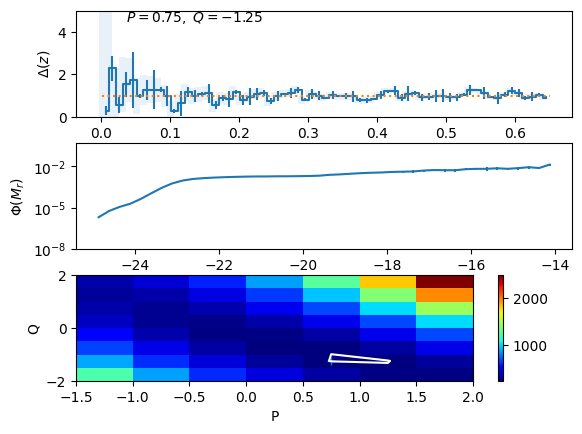

In [10]:
ev_fit(infile=df, outfile=r"E:\PhD\Jon\results\SHARK_deep_post_search.fits", ref_mlims=(0, 21.25), band_mlims=(0, 21.25), Mmin=-25, Mmax=-14, Mbin=44, zmin=0.002, zmax=0.65, nz=65, 
       band_mag_col='total_ap_dust_Z_VISTA', ref_mag_col='total_ap_dust_Z_VISTA', band_kcorr_col='kcorr_Z_VISTA', ref_kcorr_col='kcorr_Z_VISTA', 
       kcoeffs_col='kcoeffs', band_pcoeffs_col='pcoeffs_vista_z', ref_pcoeffs_col='pcoeffs_vista_z', sc_col='SC', nq_col='NQ', z_col='zobs', ra_col='ra', 
       njack = 3, ra_jack = (339, 343, 347), jack_area = np.array([50.5874321/3, 50.5874321/3, 50.5874321/3]), 
       Pbins=(-1.5, 2.0, 7), Qbins=(-2.0, 2.0, 8), method='post', err_type='jackknife', opt=False, lf_est='weight', survey='GAMAIII', area=50.5874321, 
       kc_responses=['vst_u', 'vst_g', 'vst_r', 'vst_i', 'vista_z', 'vista_y', 'vista_j', 'vista_h', 'vista_k'], 
       ref_index=4, band_index=4, H0=67.51, omega_l=0.7, z0=0.1)


************************
jswml.py version  2.0
Using Blanton kcorrections
survey :  GAMAIII
ref_mlims :  (0, 21.25)
band_mlims :  (0, 21.25)
redshift range : [ 0.002 ;  0.65 ]
area : 50.59
method :  lfchi
Kcorrect responses :  ['vst_u', 'vst_g', 'vst_r', 'vst_i', 'vista_z', 'vista_y', 'vista_j', 'vista_h', 'vista_k']
Error type :  jackknife
Jackknife regions :  (339, 343, 347)
{}
H0, omega_l, z0, area/Sr =  67.51 0.7 0.1 0.015409813039937317
319018 galaxies selected
No column r_sb; ignoring SB completeness
No column fibermag_r; ignoring redshift completeness
Setting LF bin limits Qmin, Qmax =  -2.0 2.0
zlo, zhi, Mmin, Mmax, nbins
0.002 0.2013846153846154 -40.17206337103883 -8.204670961061925 41
0.2013846153846154 0.65 -44.203621011038955 -18.92206337103883 24
0.002 0.2013846153846154 -39.766524909500376 -8.596670961061928 40
0.2013846153846154 0.65 -42.00362101103895 -18.516524909500376 23
Number of LF bins with more than 10 gals : 40 23
Q, P chi^2 grid using lfchi
P [-1.25 -0.75 -0.2

  0%|          | 0/8 [00:00<?, ?it/s]

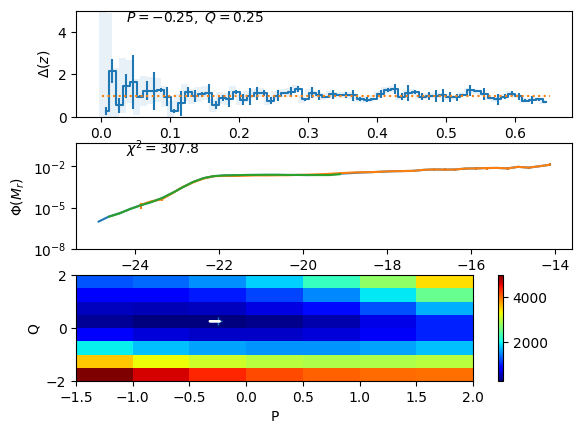

In [11]:
ev_fit(infile=df, outfile=r"E:\PhD\Jon\results\SHARK_deep_lfchi_search.fits", ref_mlims=(0, 21.25), band_mlims=(0, 21.25), Mmin=-25, Mmax=-14, Mbin=44, zmin=0.002, zmax=0.65, nz=65, 
       band_mag_col='total_ap_dust_Z_VISTA', ref_mag_col='total_ap_dust_Z_VISTA', band_kcorr_col='kcorr_Z_VISTA', ref_kcorr_col='kcorr_Z_VISTA', 
       kcoeffs_col='kcoeffs', band_pcoeffs_col='pcoeffs_vista_z', ref_pcoeffs_col='pcoeffs_vista_z', sc_col='SC', nq_col='NQ', z_col='zobs', ra_col='ra', 
       njack = 3, ra_jack = (339, 343, 347), jack_area = np.array([50.5874321/3, 50.5874321/3, 50.5874321/3]), 
       Pbins=(-1.5, 2.0, 7), Qbins=(-2.0, 2.0, 8), method='lfchi', err_type='jackknife', opt=False, lf_est='weight', survey='GAMAIII', area=50.5874321, 
       kc_responses=['vst_u', 'vst_g', 'vst_r', 'vst_i', 'vista_z', 'vista_y', 'vista_j', 'vista_h', 'vista_k'], 
       ref_index=4, band_index=4, H0=67.51, omega_l=0.7, z0=0.1)